<a href="https://colab.research.google.com/github/quickbrainlab/Bioinformatics/blob/main/Notebooks/t08_docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Docking using AutoDock VINA

The aim of these exercises is to familiarise with tools to perform the target or blid docking of small molecules onto protein targets. The reference theory is that of Lecture 8:

*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/08_StructurePredictionDocking.pdf

## Introduction

**Molecular docking simulations** explore the potential binding poses of small molecules on the **binding site** of a target protein for which an experimentally determined or predicted structure is available.

Thus, the **_druggability_** of different compounds and their binding affinity on a given protein target can be calculated for further lead optimization processes.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/docking_01.png'/>
<figcaption>FIGURE 1. In molecular docking, binding is evaluated in two steps: A) Energetics of the transition of the unbound states of ligand and target towards the conformations of the bound complex; and B) energetics of protein-ligand binding in these conformations. <br> Huey R et al (2007) <i>J Comput Chem 28(6), 1145-1152.</i></figcaption></center>
</figure>

Molecular docking programs perform a **search algorithm** in which varying conformations of a given ligand, typically generated using Monte Carlo or Genetic algorithms, are recursively evaluated until convergence to an energy minimum is reached. Finally, through an **affinity scoring function**, a ΔG [binding free energy in kcal/mol] is estimated and employed to rank the candidate poses as the sum of several energetic contributions (electrostatics, van der Waals, desolvation, etc).

###Experimental Overview

In this task you will perfom a docking assay of **indinavir**, an active component of the **antiretroviral therapy to treat HIV**, onto the binding site of its target protein, **HIV-2 protease**.

For our laboratory session, we will install and use **MGLtools** (and alternatively **pdb2pqr**) to prepare the target protein files, **OpenBabel** to prepare the ligand files, **AutoDock Vina** for the docking procedure and **py3Dmol** to establish the appropriate search grid configuration and analyze the results.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/docking_02.png' />
<figcaption>FIGURE 2. General steps of molecular docking. First, the target protein and ligand or ligands are parameterized. Then, the system is prepared by setting up the search grid. Once the docking calculation is performed, ligand poses are scored based on a given energy function. Lastly, the computational search is processed and compared against experimental data for validation <br><i>Taken from Pars Silico (en.parssilico.com).</i></figcaption></center>
</figure>

## Part 0 – Downloading and Installing the required software

Before we start, you must first **remember to start the hosted runtime in Google Colab**.

Then, we must install several pieces of software to perform this tutorial. Namely:
- **py3Dmol** for visualization of the protein structure and setting up the search grid.
- **miniconda**, a free minimal installer of **conda** for software package and environment management.
- **OpenBabel** for parameterization of our ligand(s).
- **MGLtools** for parameterization of our target protein using Gasteiger charges.
- **pdb2pqr** for parameterization of our protein using the AMBER ff99 forcefield.
- **Autodock Vina** for the docking process

**WARNING** run the next cell and wait for it to finish before going to next

In [11]:
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install()

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 7, in <module>
    from pip import main
ImportError: No module named pip
✨🍰✨ Everything looks OK!


**WARNING** run the above cell and wait for it to finish before going to next

In [12]:
!pip install -q py3Dmol kora pdb2pqr

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 7, in <module>
    from pip import main
ImportError: No module named pip


In [13]:
#Install MGLtools and OpenBabel from the bioconda repository
!conda install -q -c conda-forge rdkit zlib --yes
!conda install -q -c bioconda mgltools openbabel

Traceback (most recent call last):
  File "/usr/local/bin/conda", line 12, in <module>
    from conda.cli import main
ImportError: No module named conda.cli
Traceback (most recent call last):
  File "/usr/local/bin/conda", line 12, in <module>
    from conda.cli import main
ImportError: No module named conda.cli


Make a Task8 folder for the task in you google drive and copy  the notebook there. Then mount google drive on Colab

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set your working path

In [15]:
local_path='/content/drive/MyDrive/Structural_Bioinformatics/Task8'   # PASTE YOUR LOCAL PATH IN PLACE OF /content
%cd {local_path}

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8'
/content


In [16]:
#Checking that pdb2pqr was properly installed
!pdb2pqr -h

usage: pdb2pqr [-h] [--ff {AMBER,CHARMM,PARSE,TYL06,PEOEPB,SWANSON}]
               [--userff USERFF] [--clean] [--nodebump] [--noopt]
               [--keep-chain] [--assign-only]
               [--ffout {AMBER,CHARMM,PARSE,TYL06,PEOEPB,SWANSON}]
               [--usernames USERNAMES] [--apbs-input APBS_INPUT]
               [--pdb-output PDB_OUTPUT] [--ligand LIGAND] [--whitespace]
               [--neutraln] [--neutralc] [--drop-water] [--include-header]
               [--titration-state-method {propka}] [--with-ph PH]
               [-f FILENAMES] [-r REFERENCE] [-c CHAINS] [-i TITRATE_ONLY]
               [-t THERMOPHILES] [-a ALIGNMENT] [-m MUTATIONS] [-p PARAMETERS]
               [--log-level {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [-o PH]
               [-w WINDOW WINDOW WINDOW] [-g GRID GRID GRID]
               [--mutator MUTATOR] [--mutator-option MUTATOR_OPTIONS] [-d]
               [-l] [-k] [-q] [--protonate-all] [--version]
               input_path output_pqr

PDB2PQR v3.

3. And then we will install conda to be able to install MGLtools and OpenBabel

4. Finally, we will download the Autodock Vina program from the Scripps website and make an alias to use it during this session

In [17]:
%cd {local_path}
#Download and extract Autodock Vina from SCRIPPS
#Then, we set up an alias for vina to be treated as a native binary
!wget --no-check-certificate https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64
!chmod +x vina_1.2.5_linux_x86_64

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8'
/content
--2025-07-18 12:29:11--  https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/258054635/b208f84f-df05-4575-9991-2190698c7914?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-18T13%3A09%3A27Z&rscd=attachment%3B+filename%3Dvina_1.2.5_linux_x86_64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-18T12%3A08%3A51Z&ske=2025-07-18T13%3A09%3A27Z&sks=b&skv=2018-11-09&sig=HwioXHHydF%2Fy6mj60JpuIB%2Bg6H6UaUug319i3M6exYE%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVi

In [18]:
%alias vina '{local_path}'/vina_1.2.5_linux_x86_64

Once these software installation processes are completed, we are ready to perform our experiments

## Part 1 – Downloading and Preparing the Receptor for AutoDock Vina

1. The first step in a molecular docking procedure is to have a structure of a given target protein. While in some cases a high-quality comparative model will be used, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure.

  In such cases, a given target protein structure is downloaded from the **Protein Data Bank (PDB)** (https://www.rcsb.org/pdb) using a given accession ID. For example, the PET hydrolase solved by our lab has the accession ID 6ANE.

  For this tutorial, we will use the structure of the HIV-2 protease, solved using X-ray crystallography and deposited in the PDB with the accession ID 1HSG. We can directly download this structure from the PDB using *wget* and extracting it using *gzip*:

In [19]:
#Download a protein structure from PDB using and extract it
#!wget http://www.rcsb.org/pdb/files/[PDB_ID].pdb.gz
#!gzip -d [PDB_ID].pdb.gz
!wget http://www.rcsb.org/pdb/files/1HSG.pdb.gz
!gzip -d 1HSG.pdb.gz

--2025-07-18 12:29:12--  http://www.rcsb.org/pdb/files/1HSG.pdb.gz
Resolving www.rcsb.org (www.rcsb.org)... 128.6.159.248
Connecting to www.rcsb.org (www.rcsb.org)|128.6.159.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.rcsb.org/pdb/files/1HSG.pdb.gz [following]
--2025-07-18 12:29:12--  https://www.rcsb.org/pdb/files/1HSG.pdb.gz
Connecting to www.rcsb.org (www.rcsb.org)|128.6.159.248|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.rcsb.org/download/1HSG.pdb.gz [following]
--2025-07-18 12:29:12--  https://files.rcsb.org/download/1HSG.pdb.gz
Resolving files.rcsb.org (files.rcsb.org)... 108.156.91.39, 108.156.91.23, 108.156.91.25, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.156.91.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39400 (38K) [application/octet-stream]
Saving to: ‘1HSG.pdb.gz’

1HSG.pdb.gz         100%[===================

2. In the case of X-ray diffraction, this experimental strategy does not discriminate between electron density coming from static protein atoms or water molecules, meaning that most protein structures solved by X-ray diffraction also include so-called **crystallographic waters** (check the non-bonded red dots on the protein structure below). These molecules are not important for our particular docking simulation, and we also have to remove them.
<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/docking_03.png' />
<figcaption>FIGURE 3. Cartoon representation of HIV-2 protease dimer (PDB accession ID 1HSG), with its N-to-C-terminal residues colored from blue to red in rainbow spectrum, showing the crystallographic waters as red spheres.</i></figcaption></center>
</figure>

  Typically, this can be easily done by extracting all of the lines from the PDB file that start with **"ATOM"**, as this is how all of the atoms that belong to amino and nucleic acid residues are termed. In contrasts, the atoms from ligands, water molecules and other non-protein/non-nucleic residues are commonly referred to as **"HETATM"**. Also, the different chains of an oligomer are separated by a **"TER"** string, which is important to keep in our case.

  The following **python script** will first create a folder in which we will store all data related to our molecular docking experiment. Then, it will extract all lines matching the string "ATOM" (for the protein atoms) or "TER" (for the chain separations) into a separate PDB file for further processing. Please take a good look at it.

In [20]:
#This script will create a folder called "single-docking" for our experiment
#Then, it will print all "ATOM" and "TER" lines from a given PDB into a new file

#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path

#Then, we define the path of the folder we want to create.
#ADAPT TO YOUR GOOGLE DRIVE ORGANIZATION
singlepath = Path("single-dock/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(singlepath):
  print("path already exists")
if not os.path.exists(singlepath):
  os.mkdir(singlepath)
  print("path was succesfully created")

#Now we assign a variable "protein" with the name and extension of our pdb
protein = "1HSG.pdb"

#And we use the following script to selectively print the lines that contain the
#string "ATOM" and "TER" into a new file inside our recently created folder
with open(singlepath / "1HSG_prot.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if row[0] == "ATOM":
      g.write(line)
    elif row[0] == "TER":
      g.write("TER\n")
  g.write("END")
  print("file successfully created")

path was succesfully created
file successfully created


3. Once we printed out the "ATOM" lines of the parent PDB file, we have a new file that contains  the coordinates of our protein target.

  However, for AutoDock to perform a molecular docking experiment, the protein target must contain information about the partial charges of each atom and atom types that are compatible with AutoDock. Such format is referred to as **PDBQT**, a modification of the PDB format that also includes **charges (q)** and **AutoDock-specific atom types (t)** in two extra columns at the end of the now PDBQT file.

  Lastly, the protein target must contain **all polar hydrogens**. Most protein structures have no hydrogens included, meaning that we must add them.

  This is the part of the tutorial where you have **two different options** to proceed with your experiment!

3. a) Add the polar hydrogens of your protein and parameterize it with **Gasteiger** charges and atom types using **MGLtools** (this is the canonical option for the majority of AutoDock users)

In [21]:
#Parameterizing and adding Gasteiger charges into our protein using MGLtools
!prepare_receptor4.py -r single-dock/1HSG_prot.pdb -o single-dock/1HSG_prot.pdbqt -A hydrogens -U nphs_lps -v

set verbose to  True
read  single-dock/1HSG_prot.pdb
setting up RPO with mode= automatic and outputfilename=  single-dock/1HSG_prot.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


3. b) Add the polar hydrogens of your protein and parameterize it based on the pKa of each aminoacid at pH 7.4 with the **AMBER99ff** force field using **pdb2pqr**, followed by deletion of non-polar hydrogens and conversion into **PDBQT** file using **MGLtools**.

  In this case, pdb2pqr generates an intermediate **PQR** file, a modification of the PDB format which allows users to add charge and radius parameters to existing PDB data. This information is then unaltered during the use of **MGLtools**.

In [22]:
#First, using pdb2pqr to parameterize our receptor with AMBER99ff, maintaining
#the chain IDs and setting up the receptor at a pH of 7.4
!pdb2pqr --ff=AMBER --keep-chain --with-ph=7.4 single-dock/1HSG_prot.pdb single-dock/1HSG_prot.pqr

#Then, convert the .pqr file into a .pdbqt file while deleting non-polar
#hydrogens but without changing the AMBER parameters added to the protein
!prepare_receptor4.py -r single-dock/1HSG_prot.pqr -o single-dock/1HSG_prot.pdbqt -C -U nphs_lps -v

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: single-dock/1HSG_prot.pdb
INFO:Setting up molecule.
INFO:Created biomolecule object with 198 residues and 1514 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 2 missing atoms in biomolecule.
INFO:Added atom OXT to residue PHE A 99 at coordinates 26.780, 34.489, -10.125
INFO:Added atom OXT to residue PHE B 99 at coordinates 26.380, 42.929, 4.902
INFO:Updating disulfide bridges.
INFO:Debumping biomolecule.


**You are all set with your target protein!**

>Before we move onto preparing the ligand for molecular docking, please consider the following questions:
- Why is it important to add hydrogens for the purposes of our docking simulations?
- Why are we only adding polar hydrogens?
- Do you believe that using different force fields could have an effect on your docking results? (this is something you can actually test!)



## Part 2 – Downloading and Preparing the Ligand for AutoDock Vina

1. We now need to prepare the ligand that we will use for our docking analysis. In our case, we will use **Indinavir**. This drug is a protease inhibitor used as a component of the antiretroviral therapy to treat HIV/AIDS, aiding in decreasing the viral load. In this opportunity, we will attempt to predict the docking pose of indinavir onto the binding site of the HIV-2 protease.

  We will first start by creating a folder in which we will store our ligands for molecular docking.

In [23]:
%cd {local_path}
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path

#We will first create a path for all ligands that we will use in this tutorial
#Notice that the HOME folder for a hosted runtime in colab is /content/
ligandpath = Path("ligands/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(ligandpath):
  print("ligand path already exists")
if not os.path.exists(ligandpath):
  os.mkdir(ligandpath)
  print("ligand path was succesfully created")

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8'
/content
ligand path was succesfully created


2. Now, we will download indinavir from the **DrugBank** database (*Nucleic Acids Res
. 2006; 34, D668-72*). This is comprehensive, freely accessible, online database containing information on drugs and drug targets. You can actually check the detailed chemical, pharmacological and pharmaceutical information on Indinavir [in this DrugBank link](https://www.drugbank.ca/drugs/DB00224).

  We will download this ligand in SMILES format to continue with its preparation for molecular docking



Downloaded SMILES string: "><head><meta charset="utf-8" /><meta content="width=device-width, initial-scale=1.0" name="viewport" /><meta content="120407466,726747393" property="fb:admins" /><title>Securing Connection</title><link as="font" crossorigin="" href="../fonts/GemeliWeb-Regular.woff2" rel="preload" type="font/woff2" /><link as="font" crossorigin="" href="../fonts/GemeliWeb-Bold.woff2" rel="preload" type="font/woff2" /><link as="font" crossorigin="" href="../fonts/GemeliWeb-Light.woff2" rel="preload" type="font/woff2" /><style>@font-face{ascent-override:95%;font-display:swap;font-family:Gemeli;font-style:normal;font-weight:400;src:url(data:font/woff2;base64,d09GMgABAAAAALjAABIAAAACwEwAALhUAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP0ZGVE0cGlobgpgSHIGSNgZgAIg2CC4JkmIRCAqGuyCFwQ0LjHIAATYCJAOZWgQgBZNAB75nDIEUW4d7cgfd9j3SxIz0ZlX0IQf6cTdwQzbgT9PSOSbgwehNCjtpa/Cmj8jtAFu1v6It+////1+QbMSYB+QBr72q75bVMrem0z3AZJZ+6AuuKKXUsYhSiuaji2lGZnVwwbBq2ZQV21dsxLcI9BpDuHQXNxk7aLyrFAsejy9L2uvle7GN3mh4agQ1kmamSur
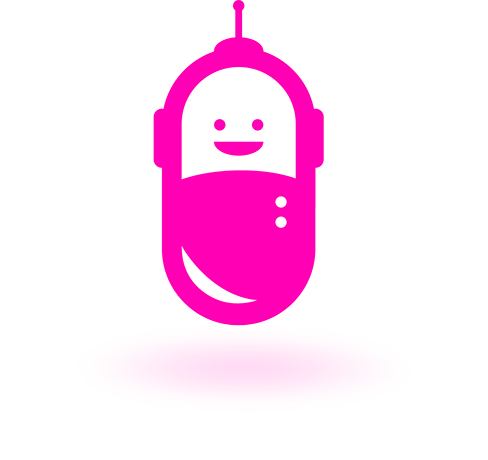

In [26]:
#Downloading Indinavir from the DrugBank database in SMILES format
# The previous attempt failed with a 403 Forbidden error.
# Let's try downloading the SMILES string directly from the DrugBank page content
import requests

url = "https://go.drugbank.com/drugs/DB00224"
response = requests.get(url)
smiles_start = response.text.find('<dd class="col-md-8 col-sm-9">') + len('<dd class="col-md-8 col-sm-9">')
smiles_end = response.text.find('</dd>', smiles_start)
smiles = response.text[smiles_start:smiles_end].strip()

with open("ligands/DB00224.smiles", "w") as f:
    f.write(smiles)

print(f"Downloaded SMILES string: {smiles}")

3. Hey! But what is a SMILES format? Well, the **Simplified Molecular-Input Line-Entry System** (SMILES) is a text notation that allows a user to represent a chemical structure in a way that can be used by the computer. The elemental notation for different types of bonds between different atoms is as follows:

  \-	for single bonds (eg. C-C or CC is CH3CH3)

  \=	for double bonds (eg. C=C for CH2CH2)

  \#	for triple bonds (eg. C#N for C≡N)

  \	for aromatic bond (eg. C\*1\*C\*C\*C\*C\*C1 or c1ccccc1 for benzene)

  \. for disconnected structures (eg. Na.Cl for NaCl)

  / and \ for double bond stereoisomers (eg. F/C=C/F for trans-1,2-difluoroethylene and F/C=C\F for cis-1,2-difluoroethylene)

  @ and @@ for enantiomers (eg. N\[C@@H](C)C(=O)O for L-alanine and N\[C@H](C)C(=O)O for D-alanine)

  **Let's take a look at the SMILES of Indinavir!**

"><head><meta charset="utf-8" /><meta content="width=device-width, initial-scale=1.0" name="viewport" /><meta content="120407466,726747393" property="fb:admins" /><title>Securing Connection</title><link as="font" crossorigin="" href="../fonts/GemeliWeb-Regular.woff2" rel="preload" type="font/woff2" /><link as="font" crossorigin="" href="../fonts/GemeliWeb-Bold.woff2" rel="preload" type="font/woff2" /><link as="font" crossorigin="" href="../fonts/GemeliWeb-Light.woff2" rel="preload" type="font/woff2" /><style>@font-face{ascent-override:95%;font-display:swap;font-family:Gemeli;font-style:normal;font-weight:400;src:url(data:font/woff2;base64,d09GMgABAAAAALjAABIAAAACwEwAALhUAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP0ZGVE0cGlobgpgSHIGSNgZgAIg2CC4JkmIRCAqGuyCFwQ0LjHIAATYCJAOZWgQgBZNAB75nDIEUW4d7cgfd9j3SxIz0ZlX0IQf6cTdwQzbgT9PSOSbgwehNCjtpa/Cmj8jtAFu1v6It+////1+QbMSYB+QBr72q75bVMrem0z3AZJZ+6AuuKKXUsYhSiuaji2lGZnVwwbBq2ZQV21dsxLcI9BpDuHQXNxk7aLyrFAsejy9L2uvle7GN3mh4agQ1kmamSur50+aXt8PVpEqSSqXm1AhfQwbFc
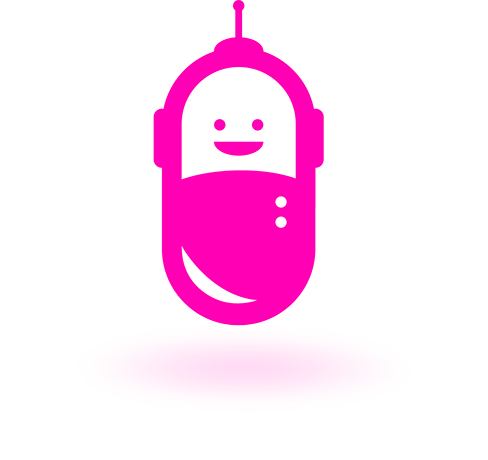

In [27]:
#Print the SMILES of indinavir to see what it is all about
print((ligandpath / "DB00224.smiles").read_text())

In [32]:
#Use the following viewer to load your SMILES as a 3D molecule
import py3Dmol
import kora.install.rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view()
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

from ipywidgets import interact,fixed,IntSlider
import ipywidgets

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

@interact
def smi2viewer(smi='PASTE HERE YOUR SMILE'):
    try:
        conf = smi2conf(smi)
        return MolTo3DView(conf).show()
    except:
        return None

DistributionNotFound: The 'kora' distribution was not found and is required by the application

4. Now, we will take this SMILES format and use it to construct and parameterize a three-dimensional structure of Indinavir in **PDBQT** format for its use in molecular docking. As with the receptor, we also have different options to prepare our ligand for molecular docking:

4. a) Use the program **babel** to convert the SMILES into a **MOL2** file without any extra work (such as searching for best conformers) except for setting the protonation state to pH 7.4, and then use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges (this is the canonical option for the majority of AutoDock users).

  Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [ ]:
!which obabel

In [ ]:
%cd {local_path}/ligands
#Converting Indinavir from SMILES into a 3D PDB format
!obabel DB00224.smiles -O indinavir.mol2 --gen3d best -p 7.4 --canonical
#Parameterizing and adding Gasteiger charges into our protein using MGLtools
#Adding -z leads to a rigid ligand without any torsions
!prepare_ligand4.py -l indinavir.mol2 -o ../single-dock/indinavir.pdbqt -U nphs_lps -v
#NOTE: for some reason, MGLtools does not recognize the ligand when inside a different folder
#Here we are deleting the temporary PDB file required for generating the PDBQT file
import os
os.remove("indinavir.mol2")

4. b) Use the program **babel** to  convert the SMILES into a 3D **MOL2** file while simultaneously performing and energy minimization using the Generalized Amber Force Field (**GAFF**). Then, use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges.

  Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [ ]:
%cd {local_path}
#Converting Indinavir from SMILES into a 3D MOL2 format and perform an energy minimization of the conformer using the GAFF forcefield
#Then, prepare ligand for docking using the Autodock script
!obabel ligands//DB00224.smiles -O indinavir.mol2 --gen3d --best --canonical --minimize --ff GAFF --steps 10000 --sd
!prepare_ligand4.py -l indinavir.mol2 -o single-dock/indinavir.pdbqt -U nphs_lps -v
import os
os.remove("indinavir.mol2")

4. c) Use the program **babel** to  convert the SMILES into a 3D **MOL2** file while simultaneously performing a weighted rotor search for the lowest energy conformer using the Generalized Amber Force Field (**GAFF**). Then, use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges.

  Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [ ]:
#Converting Indinavir from SMILES into a 3D MOL2 format and perform a weighted rotor search for lowest energy conformer
#Then, prepare ligand for docking using the Autodock script
!obabel ligands/DB00224.smiles -O indinavir.mol2 --gen3d --best --canonical --conformers --weighted --nconf 50 --ff GAFF
!prepare_ligand4.py -l indinavir.mol2 -o single-dock/indinavir.pdbqt -U nphs_lps -v
import os
os.remove("indinavir.mol2")

**You are all set with your ligand!** Now, we move onto setting up the molecular docking experiment

## Part 3 – Setting up and Performing Molecular Docking with AutoDock Vina

1. As explained in the lectures, it is necessary to define the search space for molecular docking on a given target protein through the use of a **grid box**. This grid box is usually centered within the binding, active or allosteric site of the target protein and its size will be sufficiently large such that **all binding residues are placed inside the grid box**.

  Here, we will make use of **py3Dmol** to visually inspect the protein structure in cartoon representation and to draw a grid box. The position and size of the grid box will be defined by the coordinates of its centroid and by its dimensions in x, y and z.

  To better guide the search for the optimal dimensions and coordinates of the grid box, we will also show the residues Val32, Ile47 and Val82 of HIV-2 protease.

  The script that defines the visualizer, which we called **ViewProtGrid**, is first loaded into **Colab** with the following lines of code

In [ ]:
#These definitions will enable loading our protein and then
#drawing a box with a given size and centroid on the cartesian space
#This box will enable us to set up the system coordinates for the simulation
#
#HINT: The active site of the HIV-2 protease is near the beta strands in green
#
#ACKNOWLEDGE: This script is largely based on the one created by Jose Manuel
#Napoles Duarte, Physics Teacher at the Chemical Sciences Faculty of the
#Autonomous University of Chihuahua (https://github.com/napoles-uach)
#
#First, we define the grid box
def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile,resids):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'spectrum'}})
  object.addStyle({'resi':resids},{'stick':{'colorscheme':'greenCarbon'}})

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile,resids)
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()


2. Now, we will use our ViewProtGrid to visualize the protein, binding site residues and a grid box of variable size and position that we can manipulate using a slider through *ipywidgets*. You have to edit this viewer by indicating the location of the PDB file in the *prot_PDBfile* variable (e.g. singlepath/'1HSG_prot.pdb') and the residues that you want to show from the PDB in the *resids* variable.


Examples of how to use the *protein_PDBfile* variable
>prot_PDBfile = ['1HSG_prot.pdb'] (if the PDB file is in the current path)

>prot_PDBfile = [singlepath/'1HSG_prot.pdb'] (if the PDB file is in a path defined as singlepath)


Examples of how to use the *resids* variable

>resids = [82] shows a single residue in position 82)

>resids = [82,83,84] shows residues 82, 83 or 84 separately, which you can select in the viewer

>resids = [(82,83,84)] shows residue 82, 83 and 84 in the same visualization

>resids = ['82-84'] shows residue range 82-84 in the same visualization

**NOTE:** This code fails when attempting to show two non-consecutive residues in the same visualization.


In [ ]:
#Importing py3Dmol for safety
import py3Dmol
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
interact(viewprotgrid,
#ADD YOUR PDB LOCATION AND FILENAME HERE
         prot_PDBfile =  '/content/drive/MyDrive/Structural_Bioinformatics/Task8/single-dock/1HSG_prot.pdb',
#ADD THE RESIDUES YOU WANT TO VISUALIZE HERE
         resids = ['32,47,82-84'],
         bxi=ipywidgets.IntSlider(min=-40,max=40, step=1, value=15),
         byi=ipywidgets.IntSlider(min=-40,max=40, step=1, value=29),
         bzi=ipywidgets.IntSlider(min=-40,max=40, step=1, value=4),
         bxf=ipywidgets.IntSlider(min=1,max=40, step=1, value=20),
         byf=ipywidgets.IntSlider(min=1,max=40, step=1, value=20),
         bzf=ipywidgets.IntSlider(min=1,max=40, step=1, value=20))

3. Now, we will generate a configuration file for **Autodock**. As expected, the configuration file contains information about the target protein and ligand, as well as the position and dimensions of the grid box that defines the search space.

  For defining the grid box, you will use the  box origin and size coordinates that you defined manually in the previous step.

  The following is an example file of a standard **Autodock configuration file**, including all possible variables that can be edited:


```
#CONFIGURATION FILE

#INPUT OPTIONS
receptor = [target protein pdbqt file]
ligand = [ligand pdbqt file]
flex = [flexible residues in receptor in pdbqt format]

#SEARCH SPACE CONFIGURATIONS
#Center of the box (coordinates x, y and z
center_x = [value]
center_y = [value]
center_z = [value]
#Size of the box (dimensions in x, y and z)
size_x = [value]
size_y = [value]
size_z = [value]

#OUTPUT OPTIONS
#out = [output pdbqt file for all conformations]
#log = [output log file for binding energies]

#OTHER OPTIONS
cpu = [value] # more cpus reduces the computation time
exhaustiveness = [value] # search time for finding the global minimum, default is 8
num_modes = [value] # maximum number of binding modes to generate, default is 9
energy_range = [value] # maximum energy difference between the best binding mode and the worst one displayed (kcal/mol), default is 3
seed = [value] # explicit random seed, not required
```

The following script will create this file for our docking procedure. **You will need to add the position and dimensions of your grid box**


In [31]:
%cd {local_path}

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8'
/content


In [ ]:
# You will need to add the position and dimensions of your grid box in CHANGEME places
with open(singlepath / "config_singledock","w") as f:
  f.write("#CONFIGURATION FILE (options not used are commented) \n")
  f.write("\n")
  f.write("#INPUT OPTIONS \n")
  f.write("receptor = 1HSG_prot.pdbqt \n")
  f.write("ligand = indinavir.pdbqt \n")
  f.write("#flex = [flexible residues in receptor in pdbqt format] \n")
  f.write("#SEARCH SPACE CONFIGURATIONS \n")
  f.write("#Center of the box (values bxi, byi and bzi) \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX CENTER COORDINATES
  f.write("center_x = 14 \n")
  f.write("center_y = 29 \n")
  f.write("center_z = 5 \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX DIMENSIONS
  f.write("#Size of the box (values bxf, byf and bzf) \n")
  f.write("size_x = CHANGEME \n")
  f.write("size_y = CHANGEME \n")
  f.write("size_z = CHANGEME \n")
  f.write("#OUTPUT OPTIONS \n")
  f.write("#out = \n")
  f.write("#log = \n")
  f.write("\n")
  f.write("#OTHER OPTIONS \n")
  f.write("#cpu =  \n")
  f.write("#exhaustiveness = \n")
  f.write("#num_modes = \n")
  f.write("#energy_range = \n")
  f.write("#seed = ")

4. Lastly, we will enter into the folder that we created for the docking experiment and **perform our first molecular docking with Autodock**.

  Once you execute the lines of code shown below, Autodock will show you a progress bar (if running as expected). **This simulation should not take longer than 5 min**.

  Note that we are defining the filenames of the output and log file outside the configuration file.

In [38]:
%cd {local_path}/single-dock
#Executing AutoDock Vina with our configuration file
%vina --config config_singledock --out indinavir_out.pdbqt

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8/single-dock'
/content
/bin/bash: line 1: /content/drive/MyDrive/Structural_Bioinformatics/Task8/vina_1.2.5_linux_x86_64: No such file or directory


Now you should assess the quality of your docking exercise. In general the first question is about convergence of the prediction. Above you should see something like is shown in the following figure: a list of 9 binding modes with their scoring (affinity, the lower is the better) and a lower/upper bound RMSD value calculated with respect to the best scoring pose. The lower bound is calculated using equivalent atom types, while the upper bound RMSD is calculated as a 1:1 superposition (so is more reliable).

**Ideally** if the program was super confident about the pose you should see all the nine pose with comparable score and very low upper bound RMSD. This would mean that all poses are very similar and with very similar scores.

In the **worse case** you have many modes with very similar scores but with very different poses (i.e. high upper bound RMSD). In the figure shown below we are close to such situation. This may mean that

1.   the box is TOO SMALL (i.e the program does not really know how to put the ligand)
2.   the box is TOO LARGE (i.e. the program is too free to put the ligand everywhere)
3.   the protein/ligand do not like to interact.

**At this point you can try to improve your box choice to see if you can get a more confident predition.**

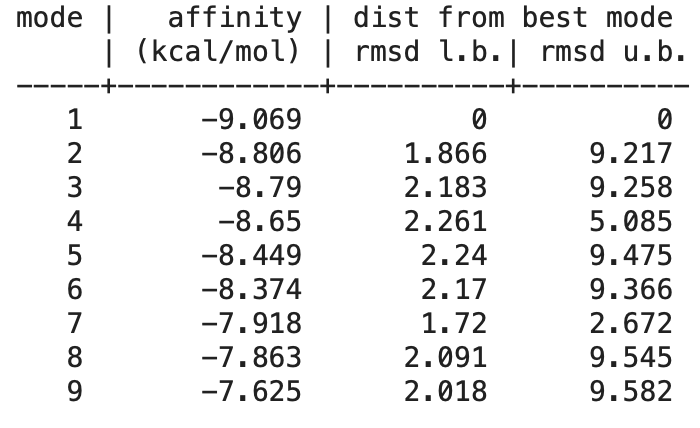

In [33]:
%cd {local_path}

[Errno 2] No such file or directory: '/content/drive/MyDrive/Structural_Bioinformatics/Task8'
/content


5. Once the molecular docking has finished running and you are happy about the results, we will compare the docking poses with the experimentally solved pose for indinavir. In fact, the structure of HIV-2 protease that you downloaded at the beginning of this tutorial was solved with indinavir bound to it.

  The following lines of code are similar to what we did with extracting the 'ATOM' lines of the PDB file, but now we are extracting the lines containing **'MK1'**, the name of the ligand in this PDB file.

In [34]:
#Here, we will be extracting Indinavir, which is present in the structure of
#HIV-2 protease (yes! this is a simulation with experimental validation!)
#The approach is similar to printing the ATOM and TER lines, but we are using
#the residue name given to the ligand in the experimentally solved structure: MK1
protein = "1HSG.pdb"

with open("single-dock/xtal_ligand.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if "MK1" in row:
      g.write(line)
  g.write("END")

6. We also need the different docking poses generated as a result of the molecular docking simulation. We will split these poses into separate PDB files using **babel**, starting with file numbered as 1 corresponding to the lowest-energy pose.

In [30]:
!pip install kora

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 7, in <module>
    from pip import main
ImportError: No module named pip


In [39]:
%cd /content/single-dock
#We need to convert our Autodock Vina results from pdbqt into pdb
#For this, we use babel
!obabel -ipdbqt indinavir_out.pdbqt -opdb -O indinavir_dock.pdb -m

*** Open Babel Error  in OpenAndSetFormat
  Cannot open single-dock/indinavir_out.pdbqt
0 molecules converted


7. Finally, we create another visualizer (**ViewDocking**) to load our protein, any docking pose of our choice and the experimentally solved binding pose of indinavir.

In [36]:
#We finally create a visualization of the protein as cartoon,
#the lowest-energy docking pose with its carbons in green
#and the experimental binding pose with its carbons in gray
def viewdocking(protein_name,ligand_name,exp_name):
  mview = py3Dmol.view(800, 400)
  mol1 = open(protein_name, 'r').read()
  mol2 = open(ligand_name, 'r').read()
  mol3 = open(exp_name, 'r').read()
  mview.addModel(mol1,'pdb')
  mview.setStyle({'model':1},{'cartoon': {'color':'spectrum'}})
  mview.addModel(mol2,'pdb')
  mview.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
  mview.addModel(mol3,'pdb')
  mview.setStyle({'resn':'MK1'},{'stick':{}})
  mview.setBackgroundColor('0xffffff')
  mview.zoomTo()
  mview.show()

8. The ViewDocking visualizer can then be used as indicated below.

In [41]:
#View docking results
viewdocking('/content/single-dock/1HSG_prot.pdb','/content/single-dock/indinavir_dock1.pdb','/content/single-dock/xtal_ligand.pdb')
#where in green you have the molecule docked by VINA while in gray the experimental pose

FileNotFoundError: [Errno 2] No such file or directory: '/content/single-dock/indinavir_dock1.pdb'

You can also visualize the results using VMD

## Part 4 – Repeat the docking using the AI based tool DiffDock

With respect to VINA DiffDock focuses instead on blind docking, that is to suggest possible binding sites instead than finding an optimal pose for a given site. In this respect it can be used in a complementary manner.

To run DiffDock you need to upload your `single-dock/1HSG_prot.pdb` and paste the smile of the ligand on their server: https://huggingface.co/spaces/simonduerr/diffdock

You can visualise the resulting poses on the webserver and download the resulting ZIP file to visualise it locally using `VMD`.

To use VMD you need to open the protein structure PDB file and one of the PDB files of the ligand. This latter one is made of multiple frames that show a diffusion process towards the bound state predicted. It may work better to visualise the ligand using the **"DynamicsBonds"** representation.